In [1]:
# import os
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/')

# from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
import scanpy as sc
import scvelo as scv

# data = sc.read('/home/evanlee/PBMC_Hao/Hao_PBMC_level1_rep_cells.h5ad')
data = sc.read('/Users/evanli/Documents/Research_datasets/PBMC_Hao/Hao_PBMC.h5ad')
data.shape

(161764, 20568)

In [3]:
label = data.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
types

['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']

In [4]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Classifier


In [5]:
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Level_1_alpha0.01/Level1_result')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'./{celltype}/{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    print(celltype, 'Feature count:', feature_df.shape[0])
    print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    print('------------------')

B Feature count: 17
B Positive feature count: 9
------------------
CD4 T Feature count: 1786
CD4 T Positive feature count: 36
------------------
CD8 T Feature count: 26
CD8 T Positive feature count: 9
------------------
DC Feature count: 1
DC Positive feature count: 0
------------------
Mono Feature count: 22
Mono Positive feature count: 14
------------------
NK Feature count: 27
NK Positive feature count: 15
------------------
other Feature count: 1
other Positive feature count: 0
------------------
other T Feature count: 2
other T Positive feature count: 0
------------------


In [6]:
all_features = []
for celltype in features_dict.keys():
    all_features += features_dict[celltype]['Gene'].tolist()

In [7]:
len(all_features)

1882

## Logistic Regression Model (with l2 Ridge regularization)
### StandardScaler

In [34]:
# Define X and y
X = data[:, all_features].X
y = data.obs['celltype.l1'].tolist()

In [35]:
X.shape

(161764, 1882)

In [36]:
len(y)

161764

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# scale the data
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(129411, 1882)
(32353, 1882)
129411
32353


In [50]:
clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
clf.fit(X_train, y_train)


LogisticRegression()

In [51]:
y_pred = clf.predict(X_test)

# evaluate performance
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 97.87%


In [52]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

precision = precision_score(y_test, y_pred, average='macro')  # average='macro'
print("Precision: {:.2f}%".format(precision * 100))
f1 = f1_score(y_test, y_pred, average='macro')
print("F1: {:.2f}%".format(f1 * 100))

Precision: 96.96%
F1: 95.79%


## Logistic Regression Model (with l2 Ridge regularization)
### CPM and log1p

In [10]:
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [54]:
# Define X and y
X = data[:, all_features].X
y = data.obs['celltype.l1'].tolist()

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(129411, 1882)
(32353, 1882)
129411
32353


In [59]:
clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
clf.fit(X_train, y_train)


LogisticRegression()

In [60]:
y_pred = clf.predict(X_test)

# evaluate performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
precision = precision_score(y_test, y_pred, average='macro')  # average='macro'
print("Precision: {:.2f}%".format(precision * 100))
f1 = f1_score(y_test, y_pred, average='macro')
print("F1: {:.2f}%".format(f1 * 100))

Accuracy: 96.84%
Precision: 95.42%
F1: 94.19%


In [94]:
clf.classes_

array(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T'],
      dtype='<U7')

In [62]:
# coefficients
clf.coef_.shape
# coef_ is of shape (1, n_features) when the given problem is binary.
# coef_ is of shape (n_classes, n_features) when the given problem is multiclass.

(8, 1882)

### LR model learning curve (all features, multiclass)

In [11]:
# Define X and y
X = data[:, all_features].X
y = data.obs['celltype.l1'].tolist()

In [12]:
print(X.shape)
print(len(y))

(161764, 1882)
161764


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve

train_sizes = [int(161764*i) for i in [0.1, 0.2, 0.4, 0.6, 0.8]]
print(train_sizes)

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0),
    X = X, y = y, 
    train_sizes = train_sizes, cv = 5,
    scoring = 'neg_mean_squared_error', 
    shuffle=True)


[16176, 32352, 64705, 97058, 129411]


In [15]:
print('Train sizes: ', train_sizes)
print('Training scores:\n\n', train_scores)
print('Validation scores:\n\n', validation_scores)

Train sizes:  [ 16176  32352  64705  97058 129411]
Training scores:

 [[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
Validation scores:

 [[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]


In [16]:
# mean value of each row
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print(train_scores_mean)
print()
print(validation_scores_mean)

[nan nan nan nan nan]

[nan nan nan nan nan]


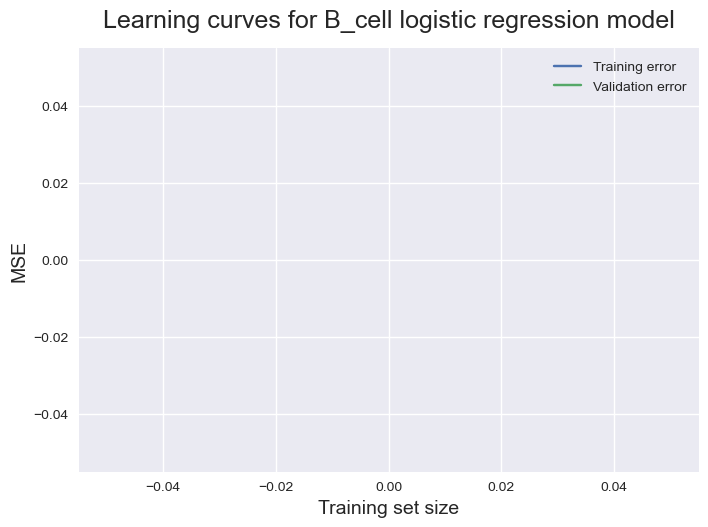

In [17]:
# Plot the learning curve
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for B_cell logistic regression model', fontsize = 18, y = 1.03)
plt.legend()

## One vs. Rest LR model for B cells

只能用B cell 的features？

In [63]:
types

['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']

In [84]:
# Define X and y
X = data[:, all_features].X
y = data.obs['celltype.l1'].tolist()
# y_B = [1 if i == 'B' else 0 for i in y]

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# change y_train and y_test to binary
y_train_B = [1 if i == 'B' else 0 for i in y_train]
y_test_B = [1 if i == 'B' else 0 for i in y_test]
print(X_train.shape)
print(X_test.shape)
print(len(y_train_B))
print(len(y_test_B))

(129411, 1882)
(32353, 1882)
129411
32353


In [95]:
clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
clf.fit(X_train, y_train)

LogisticRegression()

In [86]:
clf_B = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
clf_B.fit(X_train, y_train_B)


LogisticRegression()

In [87]:
y_pred = clf_B.predict(X_test)

# evaluate performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(y_test_B, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
precision = precision_score(y_test_B, y_pred)  # average='macro'
print("Precision: {:.2f}%".format(precision * 100))
f1 = f1_score(y_test_B, y_pred)
print("F1: {:.2f}%".format(f1 * 100))

Accuracy: 99.97%
Precision: 99.89%
F1: 99.80%


compare clf_B.coef_ with the first row of clf.coef_  
should be the same?

In [96]:
clf_B.coef_.shape

(1, 1882)

In [97]:
clf.coef_.shape

(8, 1882)

In [98]:
clf.coef_

array([[-0.00477621,  0.07081213, -0.00527981, ...,  0.00141878,
         0.00141878,  0.00121559],
       [-0.02252316, -0.03109743,  0.00899269, ..., -0.00109225,
        -0.00109225, -0.00305059],
       [ 0.01802516, -0.00920973, -0.00172359, ..., -0.00070942,
        -0.00070942, -0.00137978],
       ...,
       [-0.00059161, -0.0131439 ,  0.00449217, ...,  0.00127887,
         0.00127887,  0.00097166],
       [ 0.00983075, -0.01241601, -0.00426008, ...,  0.01025238,
         0.01025238,  0.01461882],
       [ 0.00154638,  0.00194842,  0.00082899, ..., -0.00295773,
        -0.00295773, -0.00243608]])

In [99]:
clf_B.coef_

array([[-0.01690586,  0.24375094, -0.02983054, ..., -0.03016678,
        -0.03016678, -0.02502387]])

In [101]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Classifier')

# export coefficients and LR model
import pickle

# with open('LR_multiclass_l1_a.01.pkl', 'wb') as f:
#     pickle.dump(clf, f)

# with open('LR_multiclass_l1_a.01_coef.pkl', 'wb') as f:
#     pickle.dump(clf.coef_, f)